In [1]:
# handle image
import cv2
from matplotlib import pyplot as plt

# utils
import os
import random
import imutils
import numpy as np
import pandas as pd

# machine learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import categorical_crossentropy

import tensorflow.keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configurações

In [34]:
LABEL = "CROSSENTRY_MODEL1"

IMG_SHAPE = (150, 150, 3)
EMBEDDING_DIM = 1024

RESIZED_IMG_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1])

COLAB_PATH = "drive/MyDrive/"

DATASET_PATH = COLAB_PATH +'datasets/cropped_eyes.csv'

TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1

BATCH_SIZE = 64
EPOCHS = 100

BASE_OUTPUT = COLAB_PATH + "output"
MODEL_EXTENSION = ".hdf5"

MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model" + MODEL_EXTENSION])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

SCORES = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'jaccard']


### Funções preprocessamento

In [7]:
def preprocess_image(filename):
  """
  Load the specified file as a JPEG image, preprocess it and
  resize it to the target shape.
  """
  image = cv2.imread(filename)
  image = cv2.resize(image, RESIZED_IMG_SHAPE, interpolation = cv2.INTER_AREA)
  if IMG_SHAPE[2] == 1:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #image = tf.image.resize(image, target_shape)
  return image

In [8]:
def preprocess_triplets(images, labels):
  """
  Given the filenames corresponding to the three images, load and
  preprocess them.
  """
  unique_labels = np.unique(labels)
  num_classes = len(unique_labels)
  #idx = [ { "label": i, "index_values": np.where(labels == i)[0] } for i in unique_labels ]
  idx = { "{}".format(i) :np.where(labels == i)[0] for i in unique_labels }

  pair_images = []
  pair_labels = []

  for idxA in range(len(images)):
    # grab the current image and label belonging to the current
    # iteration
    currentImage = preprocess_image(images[idxA])
    label = labels[idxA]
    # randomly pick an image that belongs to the *same* class
    # label

    idxB = np.random.choice(idx[label])
    posImage = preprocess_image(images[idxB])
    # prepare a positive pair and update the images and labels
    # lists, respectively
    pair_images.append([currentImage, posImage])
    pair_labels.append([1])

    negIdx = np.where(labels != label)[0]
    negImage = preprocess_image(images[np.random.choice(negIdx)])
    # prepare a negative pair of images and update our lists
    pair_images.append([currentImage, negImage])
    pair_labels.append([0])
  
  return (np.array(pair_images), np.array(pair_labels))

### Funções NN

In [10]:
def build_siamese_model(inputShape, embeddingDim=EMBEDDING_DIM):
  inputs = Input(inputShape)
  # define the first set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)
  # second set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(filters=64, kernel_size=(2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.3)(x)

  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  # build the model
  model = Model(inputs, outputs)
  # return the model to the calling function
  return model

In [11]:
def euclidean_distance(vectors):
  # unpack the vectors into separate lists
  (featsA, featsB) = vectors
  # compute the sum of squared distances between the vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1,
    keepdims=True)
  # return the euclidean distance between the vectors
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [28]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Treinamento Loss e Accuracy")
	plt.xlabel("Épocas")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

### Criação do modelo

In [16]:
dataset = pd.read_csv(DATASET_PATH, index_col="Unnamed: 0")

In [17]:
#dataset = dataset[:][:100]

In [18]:
(pair_images, pair_labels) = preprocess_triplets(dataset['image_path'],dataset['class'])

In [19]:
X_train, X_rem, y_train, y_rem = train_test_split(pair_images, pair_labels, test_size=TEST_SIZE + VALIDATION_SIZE)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=TEST_SIZE)

In [20]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(2720, 2, 150, 150, 3)
(2720, 1)
(932, 2, 150, 150, 3)
(932, 1)
(234, 2, 150, 150, 3)
(234, 1)


(None, None)

In [ ]:
del(pair_images)
del(pair_labels)

In [21]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [ ]:
featureExtractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                         

In [22]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [30]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=SCORES)

[INFO] compiling model...


In [ ]:
model.summary()

In [25]:
history = model.fit(
                    [X_train[:, 0], X_train[:, 1]], y_train[:],
                    validation_data=([X_valid[:, 0], X_valid[:, 1]], y_valid[:]),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS)

Epoch 1/100
43/43 [==============================] - 249s 6s/step - loss: 1.6546 - accuracy: 0.4919 - val_loss: 0.6681 - val_accuracy: 0.6416
Epoch 2/100
43/43 [==============================] - 241s 6s/step - loss: 0.6572 - accuracy: 0.4960 - val_loss: 0.6849 - val_accuracy: 0.6502
Epoch 3/100
43/43 [==============================] - 247s 6s/step - loss: 0.6464 - accuracy: 0.5393 - val_loss: 0.6527 - val_accuracy: 0.7371
Epoch 4/100
43/43 [==============================] - 249s 6s/step - loss: 0.6334 - accuracy: 0.6279 - val_loss: 0.6273 - val_accuracy: 0.7339
Epoch 5/100
43/43 [==============================] - 248s 6s/step - loss: 0.6228 - accuracy: 0.6691 - val_loss: 0.6494 - val_accuracy: 0.7264
Epoch 6/100
43/43 [==============================] - 248s 6s/step - loss: 0.6197 - accuracy: 0.6812 - val_loss: 0.6109 - val_accuracy: 0.7382
Epoch 7/100
43/43 [==============================] - 245s 6s/step - loss: 0.6156 - accuracy: 0.6827 - val_loss: 0.6499 - val_accuracy: 0.7232
Epoch 

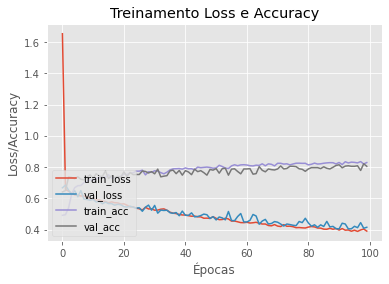

In [29]:
plot_training(history,PLOT_PATH)

### Salvar modelo

In [26]:
model.save(MODEL_PATH)

### Recuperar modelo salvo

In [33]:
model_recovered = load_model(MODEL_PATH)

### Aplicar modelo aos dados de teste

In [35]:
y_pred = model_recovered.predict([X_test[:, 0], X_test[:, 1]])

8/8 [==============================] - 5s 589ms/step


In [50]:
mapper_class = lambda value: 1 if value > 0.5 else 0

In [66]:
y_mapped = [ mapper_class(value) for value in  y_pred]
y_mapped = np.asarray(y_mapped).reshape(-1,1)

In [67]:
evaluation = abs(y_mapped - y_test)

In [72]:
(evaluation.shape[0] - sum(evaluation))/evaluation.shape[0]

array([0.8034188])